In [ ]:
# pip install tqdm

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#0. Initial Setting

In [ ]:
import numpy as np
from scipy.special import logsumexp
from scipy.special import softmax
import warnings
warnings.filterwarnings("ignore")

theta1 = np.array([[[2,-1],[-1,-1],[-1,-1]],
                   [[-1,-1],[-1,-1],[-1,-1]],
                   [[-1,-1],[-1,-1],[-1,2]]]) #a1,a2,sh np.array([2,-1])#

theta23 = np.array([0.9,0.5,0.5,0.5,0.5,0.5,
                    0.5,0.5,0.5,0.5,0.5,0.5,
                    0.5,0.5,0.5,0.5,0.5,0.1,0.1])

thread_inner = 1e-3
thread_outer = 1e-3

TimePeriod= 100
SamplePath = 1000
num_discrete = 50
discount = 0.9
dim_sh = 2
dim_ai = 3
ag = 2
dim_z = dim_sh
dim_a = dim_ai**ag

z_old = np.arange(dim_z,dtype=int) #observation
#a1_old = np.arange(dim_ai,dtype = int)
#a2_old = np.arange(dim_ai,dtype = int)
x_old = np.linspace(0,1,num_discrete) #belief

a_old = np.arange(dim_a,dtype = int)
a1_old = a_old//dim_ai
a2_old = a_old%dim_ai
print(np.sum(np.abs(a1_old*dim_ai+a2_old-a_old)))

ini_x0_1 = theta23*0.9
ini_x0_2 = theta1*0.95#[0]


0


##1. Generate Dynamic Part and Policy Part

In [ ]:
def Dynamic(theta23):
  trans_val = np.reshape(theta23[0:dim_a*dim_sh*(dim_sh-1)],[dim_ai,dim_ai,dim_sh,dim_sh-1])
  trans = np.zeros([dim_a,dim_sh,dim_sh])      #a1*2+a2,s_{t},s_{t+1}
  for sh in range(dim_sh-1):
    trans[:,:,sh] = trans_val[a1_old,a2_old,:,sh]
    trans[:,:,dim_sh-1] += trans[:,:,sh]
  trans[:,:,dim_sh-1] = 1 - trans[:,:,dim_sh-1]

  obser_val = theta23[dim_a*dim_sh*(dim_sh-1):(dim_a*dim_sh+1)*(dim_sh-1)]
  observe = np.ones([dim_sh,dim_z]) #s_{t+1},z_{t+1}
  #observe1[:,:,:,0] = np.reshape(theta23[8:16],[2,2,2])
  #observe1[:,:,:,1] = 1- observe1[:,:,:,0]
  observe[:,0] = np.array([1-obser_val[0],obser_val[0]])
  observe[:,1] = 1- observe[:,0] 

  return trans,observe
trans,observe = Dynamic(theta23)
#print(Dynamic(theta23))

def Reward(theta1):
  theta1 = np.reshape(theta1,[dim_ai,dim_ai,dim_sh])
  rw = np.zeros([dim_a,dim_sh])#a1*a2,sh
  rw= theta1[a1_old,a2_old]
  return rw
# def Reward(theta1):
#   rw = theta1[1]*np.ones([dim_a,dim_sh])#a1*a2,sh
#   rw[0,0] = rw[dim_a-1,1] = theta1[0]
#   return rw
rw = Reward(theta1)
#print(Reward(theta1))

def SigmaLambda(theta23,z_old=None,x_old=None,a1_old=None,a2_old=None,num_discrete=num_discrete,T = None): #xt,a1_t,a2_t,z_{t+1}
  trans,observe = Dynamic(theta23)  #a1*2+a2,s_{t},s_{t+1} #s_{t+1},z_{t+1}
  dy = np.einsum('ijk , kl -> ijkl',trans,observe) #a,s,s+1,z+1

  if T==None: #generate function for Q function iteration
      x_old = np.linspace(0,1,num=num_discrete)
      x_new = np.zeros([dim_a,num_discrete,dim_z])#a,x,z+1
      sigma = np.zeros([dim_a,num_discrete,dim_z])#a,x,z+1
      x_old = np.vstack([x_old,1-x_old])#s,x

      x_new_tep = np.einsum('jk , ijl -> ikl', x_old,dy[:,:,0,:])
      sigma = x_new_tep + np.einsum('jk , ijl -> ikl', x_old,dy[:,:,1,:])
      x_new = x_new_tep/sigma

  elif T==1: #generate 1 period data for data generation
      sample_size = x_old.shape
      dy = dy[a1_old*dim_ai+a2_old,:,:,z_old] # sample_size,dimsh,dimsh
      x_new = np.zeros(sample_size)
      sigma = np.zeros(sample_size)
      x_old = np.vstack([x_old,1-x_old])#dimsh,sample_size

      x_new_tep = np.einsum('ji , ij -> i', x_old,dy[:,:,0])
      sigma = x_new_tep + np.einsum('ji , ij -> i', x_old,dy[:,:,1])
      x_new = x_new_tep/sigma

  else:      #generate whole belief for recover process
      time_size = a1_old.shape[0]
      sample_size = a1_old.shape[1]
      x_new = np.zeros([time_size,sample_size]) # T, N
      sigma = np.zeros([T-1,sample_size]) # T-1 ,N
      x_new[0,:] = x_old
      #x_old = np.vstack([x_old,1-x_old]).T
      for t in range(1,T):
        a1 = a1_old[t-1,:]
        a2 = a2_old[t-1,:]
        z = z_old[t,:]
        x_old_tep = np.vstack([x_new[t-1,:],1-x_new[t-1,:]])
        dy_tep = dy[a1*dim_ai+a2,:,:,z]
        x_new_tep = np.einsum('ji , ij -> i', x_old_tep,dy_tep[:,:,0])
        sigma[t-1,:] = x_new_tep + np.einsum('ji , ij -> i', x_old_tep,dy_tep[:,:,1])
        x_new[t,:] = x_new_tep/sigma[t-1,:]

  belief_f = np.floor(x_new*(num_discrete-1))/(num_discrete-1)
  belief_c = np.ceil(x_new*(num_discrete-1))/(num_discrete-1)
  iterpolate = np.zeros(belief_f.shape)
  iterpolate[np.where((belief_f-belief_c)!=0)] = (x_new-belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]      

  return sigma,x_new,[iterpolate,np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))]

sigma,_,xiterpolate= SigmaLambda(theta23)
# print(SigmaLambda(theta23)[0][0,:,0])

def ValueIteration(theta1,sigma=sigma,xiterpolate=xiterpolate, num_discrete=num_discrete,beta = discount,
                   gamma = 0.5772,thread_inner = thread_inner,thread_outer = thread_outer): #xt, a1 or xt,a2
  rw = Reward(theta1)#a1*a2,sh
  iterpolate,belief_f,belief_c = xiterpolate[0],xiterpolate[1],xiterpolate[2]#a,x,z+1
  x_old = np.linspace(0,1,num=num_discrete)
  #x_old = np.vstack([x_old,1-x_old]).T

  pi1_new = 1/dim_ai*np.ones([dim_ai,num_discrete]) #a1,xt


  pi2_old = pi1_new.copy()
  count = 0
  #pi1_old = np.zeros([2,2])
  for ol in range(1000):
    pi1_old = pi1_new.copy()
    
    Q1_new = np.zeros([dim_ai,num_discrete]) #a1,xt
    Q2_new = np.zeros([dim_ai,num_discrete]) #a2,xt

    for il in range(1000):
      Q2_old = Q2_new.copy()
      for a2 in range(dim_ai):
        Q2_tep = 0 
        for a1 in range(dim_ai):
          #a1 = 0
          a_tmp = a1*dim_ai+a2
          it0,bf0,bc0 = iterpolate[a_tmp],belief_f[a_tmp],belief_c[a_tmp]
          #print(len([it0*Q2_old[a2_fw,bf0].copy() + (1-it0)*Q2_old[a2_fw,bc0].copy() for a2_fw in range(dim_ai)]))
          V2_a10 = np.einsum('ij , kij ->  kij',it0,Q2_old[:,bf0]) +\
                   np.einsum('ij , kij ->  kij',1-it0,Q2_old[:,bc0])

          Q2_tepa10 = x_old * rw[a_tmp,0] + (1-x_old) * rw[a_tmp,1] + beta * np.sum(sigma[a_tmp]*(gamma+logsumexp(V2_a10,axis=0)),axis=1)
          Q2_tep += pi1_old[a1]*Q2_tepa10
        
        Q2_new[a2] = Q2_tep
      #print(il,np.max(np.abs((Q2_new-Q2_old)/Q2_old)),np.max(np.abs(Q2_old)))
      if np.max(np.abs((Q2_new-Q2_old)/Q2_old)) <thread_inner: 
        #print('Q2',il,np.max(np.abs((Q2_new-Q2_old)/Q2_old)))
        break

    pi2_new = softmax(Q2_new,axis=0)
    #if np.max(np.abs((pi2_old-pi2_new)/pi2_old)) <thread_outer:
    count = np.max(np.abs((pi2_old-pi2_new)/pi2_old))


    pi2_old = pi2_new.copy()
    for il in range(1000):
      Q1_old = Q1_new.copy()
      for a1 in range(dim_ai):
        Q1_tep = 0
        for a2 in range(dim_ai):
          #a2 = 0
          a_tmp = a1*dim_ai+a2
          it0,bf0,bc0 = iterpolate[a_tmp],belief_f[a_tmp],belief_c[a_tmp]
          V1_a20 =  np.einsum('ij , kij ->  kij',it0,Q1_old[:,bf0]) +\
                   np.einsum('ij , kij ->  kij',1-it0,Q1_old[:,bc0])
          Q1_tepa20 = x_old * rw[a_tmp,0] + (1-x_old) * rw[a_tmp,1] + beta * np.sum(sigma[a_tmp]*(gamma+logsumexp(V1_a20,axis=0)),axis=1)
          Q1_tep += pi2_old[a2]*Q1_tepa20

          
        Q1_new[a1] = Q1_tep
      #print(il,np.max(np.abs((Q1_new-Q1_old)/Q1_old)),np.max(np.abs(Q1_old)))

      if np.max(np.abs((Q1_new-Q1_old)/Q1_old)) <thread_inner:
        #print('Q1',il,np.max(np.abs((Q1_new-Q1_old)/Q1_old)))
        break

    pi1_new = softmax(Q1_new,axis=0)
    
    #print('pi1 pi2',ol,np.max(np.abs((pi1_old-pi1_new)/pi1_old)),count)

    if np.max(np.abs((pi1_old-pi1_new)/pi1_old)) <thread_outer and count<thread_outer:
      #print(ol,np.max(np.abs((pi1_old-pi1_new)/pi1_new)))
      break
  return Q1_new,Q2_new,pi1_new,pi2_new

sigma,_,xiterpolate= SigmaLambda(theta23)
Q1,Q2,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate)

In [ ]:
np.linalg.matrix_rank(np.round_(np.einsum('ij , kj -> jik',pi1,np.stack([x_old,1-x_old],axis=0)).reshape([num_discrete,-1]),3))

6

Check Q value function works (doesn't depend on discrete intervals) 

100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


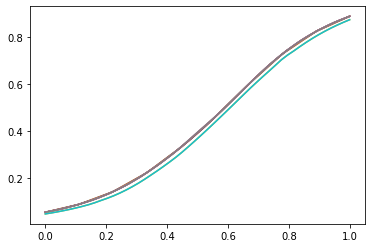

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
discrete_tol = 10*(1+np.arange(5))
Q1_plot = []
Q2_plot = []
pi1_plot = []
pi2_plot = []
for num_disc in tqdm(discrete_tol):
  x_old_test = np.linspace(0,1,num_disc)
  sigma,_,xiterpolate= SigmaLambda(theta23,num_discrete=num_disc)

  Q1,Q2,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate, num_discrete=num_disc)
  Q1_plot.append(Q1)
  Q2_plot.append(Q2)
  pi1_plot.append(pi1)
  pi2_plot.append(pi2)

for i in range(len(discrete_tol)):
  plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][0],np.linspace(0,1,discrete_tol[i]),pi1_plot[i][0])

##2. Data Generation Process

In [ ]:
##################################Global Parameter#################################
# theta1 = np.array([4.57,2.5])#np.array([[[4.57,3.41],[3.86,3.18]],[[2.69,2.75],[3.58,4.57]]]) #s,a1,a2
# theta23 = np.array([0.9,0.5,0.9,0.2])
# TimePeriod= 150
# SamplePath = 300
# num_discrete = 100
# z_old = np.arange(2,dtype=int) #observation
# a1_old = np.arange(2,dtype = int)
# a2_old = np.arange(2,dtype = int)
# x_old = np.linspace(0,1,num_discrete) #belief
###################################################################################
from tqdm import tqdm
def DataGeneration(theta1 = theta1,theta23=theta23,T=TimePeriod,N=SamplePath,Nsub = 50,num_discrete=num_discrete):
  HdState = np.zeros([T,N],dtype= int)    #hidden state
  ObState = np.zeros([T,N],dtype = int) #observation state
  belief = np.zeros([T,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action

  HdState[0,:] = np.random.randint(0,dim_sh,size=N)
  belief[0,:] = np.kron(np.ones(int(N/Nsub)),np.linspace(0,1,int(Nsub)))#np.random.uniform(size=N)
  ObState[0,:] = np.int_(np.random.random(size=N)>belief[0,:])
      

  trans,observe = Dynamic(theta23)
  sigma,_,xiterpolate= SigmaLambda(theta23,num_discrete=num_discrete)
  _,_,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate,num_discrete=num_discrete)
  for t in tqdm(range(T)):
    # iterpolate belief
    belief_f = np.floor(belief[t,:] *(num_discrete-1))/(num_discrete-1)
    belief_c = np.ceil(belief[t,:] *(num_discrete-1))/(num_discrete-1)
    iterpolate = np.zeros(belief_f.shape)
    iterpolate[np.where((belief_f-belief_c)!=0)] = (belief[t,:] -belief_c)[np.where((belief_f-belief_c)!=0)]/(belief_f-belief_c)[np.where((belief_f-belief_c)!=0)]
    belief_fint,belief_cint = np.int_(belief_f*(num_discrete-1)),np.int_(belief_c*(num_discrete-1))

    # generate new action for both agents
    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[0,belief_fint] + (1-iterpolate)*pi1[0,belief_cint]
    p12 = iterpolate*pi1[1,belief_fint] + (1-iterpolate)*pi1[1,belief_cint]

    action1[t,:] = np.int_(p11<=action_mat1) + np.int_(p11+p12<=action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[0,belief_fint] + (1-iterpolate)*pi2[0,belief_cint]
    p22 = iterpolate*pi2[1,belief_fint] + (1-iterpolate)*pi2[1,belief_cint]

    action2[t,:] = np.int_(p21<=action_mat2) + np.int_(p21+p22<=action_mat2)
    
    if t!=T-1:
      # generate new hidden state and observation state
      state_mat1 = np.random.random(size=N)
      HdState[t+1,:] = np.int_(trans[action1[t,:]*dim_ai+action2[t,:],HdState[t,:],0]<=state_mat1)
      state_mat2 = np.random.random(size=N)
      ObState[t+1,:] = np.int_(observe[HdState[t+1,:],0]<=state_mat2)

      # update new belief
      _,belief[t+1,:],_ = SigmaLambda(theta23,z_old=ObState[t+1,:] ,x_old=belief[t,:],a1_old=action1[t,:],a2_old=action2[t,:],num_discrete=num_discrete,T = 1)
  return ObState, action1,action2,belief,HdState


ObState, action1,action2,belief,HdState= DataGeneration()
#haha = SigmaLambda()

100%|██████████| 100/100 [00:00<00:00, 2300.56it/s]


##3.1 Recover Dynamic Part

In [ ]:
theta23

array([0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.1, 0.1])

In [ ]:
from scipy.optimize import minimize
lower_bound = 1e-4
# ini_x0 = theta23
print('start from:',ini_x0_1 )

def func1(theta23,ObState=ObState, action1=action1,action2 = action2,x0=belief[0,:],T=TimePeriod):
  sigma,_,_ = SigmaLambda(theta23,z_old=ObState ,x_old=x0,a1_old=action1,a2_old=action2,num_discrete=num_discrete,T = T)
  res = -np.sum(np.log(sigma))
  print(theta23,res)
  return res

res1 = minimize(func1,ini_x0_1, bounds=[[0+lower_bound,1-lower_bound]]*len(ini_x0_1))
#trans_est = np.vstack([res1.x,1-res1.x]).T.reshape([2,2,2,2])
print(res1)
print('error: {:.4f}%, relative error: {:.4f}%'.format(100*np.linalg.norm(theta23-res1.x),
                                                       100*np.linalg.norm(theta23-res1.x)/np.linalg.norm(theta23)))

start from: [0.81 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45
 0.45 0.45 0.45 0.09 0.09]
[0.81 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45
 0.45 0.45 0.45 0.09 0.09] 56314.48683071219
[0.81000001 0.45       0.45       0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.09
 0.09      ] 56314.486748986485
[0.81       0.45000001 0.45       0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.09
 0.09      ] 56314.486822465966
[0.81       0.45       0.45000001 0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.09
 0.09      ] 56314.48682500938
[0.81       0.45       0.45       0.45000001 0.45       0.45
 0.45       0.45       0.45       0.45       0.45       0.45
 0.45   

##3.2 Recover Reward Part

> Indented block



In [ ]:
theta1.reshape(-1)

array([ 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        2])

In [59]:
#ini_x0_2 = theta1#[0]
print('start from:',ini_x0_2 )
sigma,_,xiterpolate= SigmaLambda(res1.x,num_discrete=num_discrete)
_,_,beliefIP = SigmaLambda(res1.x,z_old=ObState ,x_old=belief[0,:],a1_old=action1,a2_old=action2,num_discrete=num_discrete,T = TimePeriod)

def func2(theta1,sigma = sigma,xiterpolate=xiterpolate,beliefIP=beliefIP,action1 = action1,action2 = action2,T=TimePeriod):
  #theta1 = theta1.reshape([2,2,2])
  #_,_,pi1,pi2 = ValueIteration(np.array([theta1,1.5]),sigma,xiterpolate)
  _,_,pi1,pi2 = ValueIteration(theta1,sigma,xiterpolate)
  p1 = beliefIP[0] *pi1[action1,beliefIP[1]] + (1-beliefIP[0]) *pi1[action1,beliefIP[2]]
  p2 = beliefIP[0] *pi2[action2,beliefIP[1]] + (1-beliefIP[0]) *pi2[action2,beliefIP[2]]
  res = - np.sum(np.log(p1)) -np.sum(np.log(p2))
  print(theta1,res)
  return res

res2 = minimize(func2,ini_x0_2,bounds = [(1e-6,100)]+[(-100,-1e-6)]*16+[(1e-6,100)])#method='Nelder-Mead')
print(res2)
print('error: {:.4f}%, relative error: {:.4f}%'.format(100*np.linalg.norm(theta1.reshape(-1)-res2.x),
                                                       100*np.linalg.norm(theta1.reshape(-1)-res2.x)/np.linalg.norm(theta1)))

Streaming output truncated to the last 5000 lines.
[ 1.9519866  -1.01535318 -0.98365952 -0.79130221 -0.98031776 -1.17092022
 -0.99456082 -0.90045527 -0.97840643 -0.51256693 -1.54551498 -1.13306268
 -1.0312042  -1.15034697 -1.1946404  -1.22250508 -0.55155615  1.92311882] 112582.12613991715
[ 1.9519866  -1.01535318 -0.98365952 -0.79130221 -0.98031777 -1.17092021
 -0.99456082 -0.90045527 -0.97840643 -0.51256693 -1.54551498 -1.13306268
 -1.0312042  -1.15034697 -1.1946404  -1.22250508 -0.55155615  1.92311882] 112582.12613990167
[ 1.9519866  -1.01535318 -0.98365952 -0.79130221 -0.98031777 -1.17092022
 -0.99456081 -0.90045527 -0.97840643 -0.51256693 -1.54551498 -1.13306268
 -1.0312042  -1.15034697 -1.1946404  -1.22250508 -0.55155615  1.92311882] 112582.12613990466
[ 1.9519866  -1.01535318 -0.98365952 -0.79130221 -0.98031777 -1.17092022
 -0.99456082 -0.90045526 -0.97840643 -0.51256693 -1.54551498 -1.13306268
 -1.0312042  -1.15034697 -1.1946404  -1.22250508 -0.55155615  1.92311882] 112582.12613

# Result

In [60]:
print(res1)
print('error: {:.4f}%, relative error: {:.4f}%'.format(100*np.linalg.norm(theta23-res1.x),
                                                       100*np.linalg.norm(theta23-res1.x)/np.linalg.norm(theta23)))
print(res2)
print('error: {:.4f}%, relative error: {:.4f}%'.format(100*np.linalg.norm(theta1.reshape(-1)-res2.x),
                                                       100*np.linalg.norm(theta1.reshape(-1)-res2.x)/np.linalg.norm(theta1)))

      fun: 55749.40369726793
 hess_inv: <19x19 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.1717126 ,  0.85710781,  1.10085238, -0.26484486,  0.4634785 ,
        0.27721399,  0.47075446,  1.22308847, -1.75205058, -0.47875801,
        1.04118954,  0.27721398, -0.80108293, -0.36307028,  0.29831426,
       -0.49549271,  0.67157089, -4.13347152, -5.27288649])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 860
      nit: 37
     njev: 43
   status: 0
  success: True
        x: array([0.90180024, 0.49891468, 0.51927767, 0.4741046 , 0.50027923,
       0.48975535, 0.47828941, 0.55352295, 0.53601929, 0.4619315 ,
       0.47197978, 0.50199803, 0.49380592, 0.51955745, 0.48851431,
       0.50259645, 0.49773259, 0.10052106, 0.10302248])
error: 9.2723%, relative error: 4.2190%
      fun: 112581.46636538739
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([-44.3353204 ,  -6.90197343,  -9.23027978,  -6.40429786,
         5.26779329,   

In [62]:
xc = np.stack([x_old,1-x_old],axis=0) # sh, x
pi_2 = np.einsum('ij , kj ->jik',xc,pi2).reshape([num_discrete,-1])
print(np.round_(pi_2,2))
for i in range(10):
  print(np.linalg.matrix_rank(np.round_(pi_2,i)))
print(np.round_(pi2,2).T)

[[0.   0.   0.   0.05 0.05 0.9 ]
 [0.   0.   0.02 0.05 0.05 0.87]
 [0.   0.   0.04 0.06 0.06 0.85]
 [0.   0.   0.05 0.06 0.06 0.82]
 [0.01 0.01 0.07 0.06 0.06 0.79]
 [0.01 0.01 0.09 0.07 0.07 0.76]
 [0.01 0.01 0.1  0.07 0.07 0.74]
 [0.01 0.01 0.12 0.08 0.07 0.71]
 [0.02 0.02 0.13 0.08 0.08 0.68]
 [0.02 0.02 0.15 0.09 0.08 0.65]
 [0.02 0.02 0.16 0.09 0.09 0.62]
 [0.03 0.03 0.17 0.1  0.09 0.59]
 [0.03 0.03 0.18 0.1  0.09 0.56]
 [0.04 0.04 0.19 0.11 0.1  0.53]
 [0.05 0.04 0.2  0.12 0.1  0.49]
 [0.06 0.05 0.2  0.12 0.11 0.46]
 [0.06 0.05 0.21 0.13 0.11 0.43]
 [0.07 0.06 0.21 0.14 0.11 0.4 ]
 [0.09 0.07 0.22 0.15 0.11 0.37]
 [0.1  0.07 0.22 0.15 0.12 0.34]
 [0.11 0.08 0.22 0.16 0.12 0.32]
 [0.12 0.09 0.22 0.17 0.12 0.29]
 [0.14 0.09 0.22 0.17 0.11 0.27]
 [0.16 0.1  0.21 0.18 0.11 0.24]
 [0.17 0.1  0.21 0.18 0.11 0.22]
 [0.19 0.11 0.21 0.19 0.11 0.2 ]
 [0.21 0.11 0.2  0.19 0.1  0.18]
 [0.24 0.12 0.2  0.19 0.1  0.16]
 [0.26 0.12 0.19 0.19 0.09 0.14]
 [0.28 0.12 0.18 0.2  0.09 0.13]
 [0.31 0.1

In [ ]:
np.linalg.matrix_rank(np.array([[0.95,0.05,0,0],[0.9,0.06,0.04,0],[0,0.04,0.06,0.9],[0,0,0.05,0.95]]))

4